<a href="https://colab.research.google.com/github/alysondv/Fundamentos-ETL/blob/main/Aulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neste estudo será utilizado o dataset de ocorrências aeronáuticas na aviação civil Brasileira disponibilizado pela iniciativa [Opendata AIG Brazil](https://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileira).

Relacionamento entre as tabelas

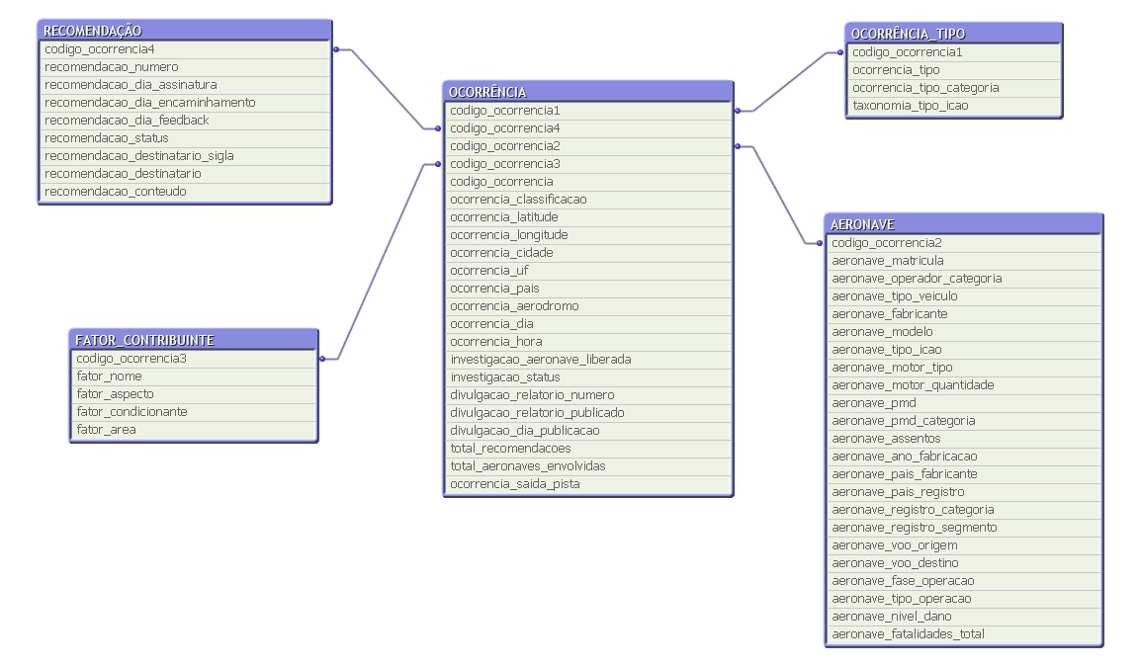

Imports necessários

In [31]:
pip install pandera

     |████████████████████████████████| 166 kB 24.3 MB/s 


In [32]:
import pandas as pd
import pandera as pa

### Extração

In [5]:
!wget "http://sistema.cenipa.aer.mil.br/cenipa/media/opendata/ocorrencia.csv"

--2021-11-09 00:41:12--  http://sistema.cenipa.aer.mil.br/cenipa/media/opendata/ocorrencia.csv
Resolving sistema.cenipa.aer.mil.br (sistema.cenipa.aer.mil.br)... 189.9.13.91
Connecting to sistema.cenipa.aer.mil.br (sistema.cenipa.aer.mil.br)|189.9.13.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 916054 (895K) [text/csv]
Saving to: ‘ocorrencia.csv’

ocorrencia.csv      100%[===================>] 894.58K   320KB/s    in 2.8s    

2021-11-09 00:41:17 (320 KB/s) - ‘ocorrencia.csv’ saved [916054/916054]



 Ler o arquivo que contem os dados que queremos transformar em informação

In [61]:
ds = pd.read_csv('ocorrencia.csv', sep=";", parse_dates=['ocorrencia_dia'], dayfirst=True)
ds.dtypes

codigo_ocorrencia                          int64
codigo_ocorrencia1                         int64
codigo_ocorrencia2                         int64
codigo_ocorrencia3                         int64
codigo_ocorrencia4                         int64
ocorrencia_classificacao                  object
ocorrencia_latitude                       object
ocorrencia_longitude                      object
ocorrencia_cidade                         object
ocorrencia_uf                             object
ocorrencia_pais                           object
ocorrencia_aerodromo                      object
ocorrencia_dia                    datetime64[ns]
ocorrencia_hora                           object
investigacao_aeronave_liberada            object
investigacao_status                       object
divulgacao_relatorio_numero               object
divulgacao_relatorio_publicado            object
divulgacao_dia_publicacao                 object
total_recomendacoes                        int64
total_aeronaves_envo

Para facilitar o processo de entendimento das etapas que serão realizadas durante o estudo, algumas features serão excluídas, que são:
* codigo_ocorrencia1,
* codigo_ocorrencia3,
* codigo_ocorrencia4,
* ocorrencia_latitude,
* ocorrencia_longitude,
* ocorrencia_pais,
* investigacao_aeronave_liberada,
* investigacao_status,
* divulgacao_relatorio_numero,
* divulgacao_relatorio_publicado,
* divulgacao_dia_publicacao
* total_aeronaves_envolvidas e 
* ocorrencia_saida_pista.

In [62]:
ds = ds.drop(['codigo_ocorrencia1','codigo_ocorrencia3','codigo_ocorrencia4','ocorrencia_latitude',
         'ocorrencia_longitude','ocorrencia_pais','investigacao_aeronave_liberada',
         'investigacao_status','divulgacao_relatorio_numero','divulgacao_relatorio_publicado',
         'divulgacao_dia_publicacao','total_aeronaves_envolvidas','ocorrencia_saida_pista'], axis=1)

In [63]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114 entries, 0 to 6113
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   codigo_ocorrencia         6114 non-null   int64         
 1   codigo_ocorrencia2        6114 non-null   int64         
 2   ocorrencia_classificacao  6114 non-null   object        
 3   ocorrencia_cidade         6114 non-null   object        
 4   ocorrencia_uf             6114 non-null   object        
 5   ocorrencia_aerodromo      6114 non-null   object        
 6   ocorrencia_dia            6114 non-null   datetime64[ns]
 7   ocorrencia_hora           6113 non-null   object        
 8   total_recomendacoes       6114 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 430.0+ KB


Criando o modelo de schema

In [68]:
schema = pa.DataFrameSchema(
    columns = {
        "codigo_ocorrencia":pa.Column(pa.Int),
        "codigo_ocorrencia2":pa.Column(pa.Int),
        "ocorrencia_classificacao":pa.Column(pa.String),
        "ocorrencia_cidade":pa.Column(pa.String),
        "ocorrencia_uf":pa.Column(pa.String, pa.Check.str_length(2,2)),
        "ocorrencia_aerodromo":pa.Column(pa.String),
        "ocorrencia_dia":pa.Column(pa.DateTime),
        "ocorrencia_hora":pa.Column(pa.String, pa.Check.str_matches(r'^([0-1]?[0-9]|[2][0-3]):([0-5][0-9]):([0-5][0-9])?$'), nullable=True),
        "total_recomendacoes":pa.Column(pa.Int)
    }
)

Validação dos dados

In [70]:
# corrigindo 3 asteriscos no ocorrencia uf
ds.at[2227, 'ocorrencia_uf'] = '**'
ds.at[5855, 'ocorrencia_uf'] = '**'

In [71]:
schema.validate(ds)

,codigo_ocorrencia,codigo_ocorrencia2,ocorrencia_classificacao,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,total_recomendacoes
0,40211,40211,INCIDENTE,RIO DE JANEIRO,RJ,****,2010-01-03,12:00:00,0
1,40349,40349,INCIDENTE,BELÉM,PA,SBBE,2010-01-03,11:05:00,0
2,40351,40351,INCIDENTE,RIO DE JANEIRO,RJ,SBRJ,2010-01-03,03:00:00,0
3,39527,39527,ACIDENTE,LUCAS DO RIO VERDE,MT,****,2010-01-04,17:30:00,0
4,40324,40324,INCIDENTE,PELOTAS,RS,SBPK,2010-01-05,19:25:00,0
...,...,...,...,...,...,...,...,...,...
6109,80245,80245,INCIDENTE,RECIFE,PE,SBRF,2021-08-15,15:05:00,0
6110,80247,80247,INCIDENTE,PORTO VELHO,RO,SBPV,2021-08-16,02:30:00,0
6111,80251,80251,INCIDENTE,BELÉM,PA,SBBE,2021-08-17,15:45:00,0
6112,80257,80257,ACIDENTE,DOM AQUINO,MT,****,2021-08-18,16:00:00,0
